# Predicting T-shirt size using the ANSUR II dataset
We will here try to predict a persons t-shirt size given the weight and height of the person. We will use the ANSUR II dataset which contains a lot of information about the physical attributes of a large number of people. 

We will first try to map the persons in the dataset to a t-shirt size. It is hard to find a concise size chart for t-shirt so we will create our own, initial chart, based on these assumptions:

We will only look at two measurements, Shoulder Width and Chest Circumference.

Our first problem is that Shoulder Width is not one of the measurements taken in the dataset. But we have Biacromial Breadth which is the distance between the two acromion processes. We will assume that this is the same as Shoulder Width.

We will then have these initial rules:

| Size | Percentile |
|------|------------|
| XS   | 0-5        |
| S    | 5-25       |
| M    | 25-50      |
| L    | 50-75      |
| XL   | 75-90      |
| XXL  | 90-97      |
| XXXL | 97-100     |

## Inspect the data

In [1]:
import pandas as pd

In [2]:
female = pd.read_csv('./data/female.csv')
male = pd.read_csv('./data/male.csv')

In [3]:
print(f'For women we have (rows, columns) {female.shape}')
print(f'For women we have (rows, columns) {male.shape}')


For women we have (rows, columns) (1986, 108)
For women we have (rows, columns) (4082, 108)


## Checking the percentiles

In [4]:
def compute_percentile_ranges(column):
    # Define percentile ranges
    ranges = [(0, 5), (5, 25), (25, 50), (50, 75), (75,90), (90, 97), (97, 100)]

    percentiles = {(low, high): (column.quantile(low/100), column.quantile(high/100)) for low, high in ranges}

    counts = {}

    for r, (low, high) in percentiles.items():
        counts[r] = ((column >= low) & (column < high)).sum()
    
    return counts

print(compute_percentile_ranges(female['chestcircumference']))
print(compute_percentile_ranges(female['biacromialbreadth']))

print(compute_percentile_ranges(male['chestcircumference']))
print(compute_percentile_ranges(male['biacromialbreadth']))

{(0, 5): np.int64(100), (5, 25): np.int64(396), (25, 50): np.int64(492), (50, 75): np.int64(499), (75, 90): np.int64(299), (90, 97): np.int64(140), (97, 100): np.int64(59)}
{(0, 5): np.int64(93), (5, 25): np.int64(377), (25, 50): np.int64(477), (50, 75): np.int64(541), (75, 90): np.int64(297), (90, 97): np.int64(139), (97, 100): np.int64(61)}
{(0, 5): np.int64(199), (5, 25): np.int64(810), (25, 50): np.int64(1025), (50, 75): np.int64(1012), (75, 90): np.int64(616), (90, 97): np.int64(295), (97, 100): np.int64(124)}
{(0, 5): np.int64(191), (5, 25): np.int64(787), (25, 50): np.int64(989), (50, 75): np.int64(1079), (75, 90): np.int64(610), (90, 97): np.int64(303), (97, 100): np.int64(122)}


## Generate the t-shirt size chart

In [5]:
def compute_size_percentile_measurements(data, chest_column, shoulder_column):
    sizes = ['XS', 'S', 'M', 'L', 'XL', '2XL', '3XL']
    ranges = [0, 5, 25, 50, 75, 90, 97]

    #Compute the values for each percentile for chest and shoulder
    chest_percentiles = {p: data[chest_column].quantile(p/100) for p in ranges}
    shoulder_percentiles = {p: data[shoulder_column].quantile(p/100) for p in ranges}
    
    # Map the t-shirt sizes to the corresponding chest and shoulder measurements
    size_mappings = {}
    for i, size in enumerate(sizes):
        size_mappings[size] = {
            'Chest': int(chest_percentiles[ranges[i]]),
            'Shoulder': int(shoulder_percentiles[ranges[i]])
        }
    
    return size_mappings





print(compute_size_percentile_measurements(female, 'chestcircumference', 'biacromialbreadth'))
print(compute_size_percentile_measurements(male, 'chestcircumference', 'biacromialbreadth'))


{'XS': {'Chest': 695, 'Shoulder': 283}, 'S': {'Chest': 824, 'Shoulder': 335}, 'M': {'Chest': 889, 'Shoulder': 353}, 'L': {'Chest': 940, 'Shoulder': 365}, 'XL': {'Chest': 999, 'Shoulder': 378}, '2XL': {'Chest': 1057, 'Shoulder': 389}, '3XL': {'Chest': 1117, 'Shoulder': 400}}
{'XS': {'Chest': 774, 'Shoulder': 337}, 'S': {'Chest': 922, 'Shoulder': 384}, 'M': {'Chest': 996, 'Shoulder': 403}, 'L': {'Chest': 1056, 'Shoulder': 415}, 'XL': {'Chest': 1117, 'Shoulder': 428}, '2XL': {'Chest': 1172, 'Shoulder': 441}, '3XL': {'Chest': 1233, 'Shoulder': 452}}


In [22]:
female_sizes = {
    'XS': {'Chest': 695, 'Shoulder': 283}, 
    'S': {'Chest': 824, 'Shoulder': 335}, 
    'M': {'Chest': 889, 'Shoulder': 353}, 
    'L': {'Chest': 940, 'Shoulder': 365}, 
    'XL': {'Chest': 999, 'Shoulder': 378}, 
    '2XL': {'Chest': 1057, 'Shoulder': 389}, 
    '3XL': {'Chest': 1117, 'Shoulder': 400}
}

male_sizes = {
    'XS': {'Chest': 774, 'Shoulder': 337}, 
    'S': {'Chest': 922, 'Shoulder': 384}, 
    'M': {'Chest': 996, 'Shoulder': 403}, 
    'L': {'Chest': 1056, 'Shoulder': 415}, 
    'XL': {'Chest': 1117, 'Shoulder': 428}, 
    '2XL': {'Chest': 1172, 'Shoulder': 441}, 
    '3XL': {'Chest': 1233, 'Shoulder': 452}
    }

In [24]:
def get_size(data, size_chart):
    matches= {size: 0 for size in size_chart.keys()}
    ties = 0

    for _, row in data.iterrows():
        possible_sizes = []

        for size, measurements in size_chart.items():
            if (row['biacromialbreadth'] <= measurements['Shoulder'] and
                row['chestcircumference'] <= measurements['Chest']):
                possible_sizes.append(size)

        if len(possible_sizes) == 1: 
            matches[possible_sizes[0]] += 1
        elif len(possible_sizes) > 1: 
            ties += 1
    
    return matches, ties

In [25]:
female_matches, female_ties = get_size(female, female_sizes)
male_matches, male_ties = get_size(male, male_sizes)

print('Female matches:', female_matches)
print('Female ties:', female_ties)
print('male matches:', male_matches)
print('male ties:', male_ties)


Female matches: {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 236}
Female ties: 1642
male matches: {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 434}
male ties: 3437


In [26]:
def create_overlapping_size_chart(original_chart):
    overlapping_chart = {}

    sizes = list(original_chart.keys())

    for i, size in enumerate(sizes):
        overlapping_chart[size] = {}
        if i == 0:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest'], original_chart[sizes[i+1]]['Chest']+5]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder'], original_chart[sizes[i+1]]['Shoulder']+5]

        elif i == len(sizes)-1:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest']-5, original_chart[size]['Chest']+1000]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder']-5, original_chart[size]['Shoulder']+1000]
        
        else:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest']-5, original_chart[sizes[i+1]]['Chest']+5]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder']-5, original_chart[sizes[i+1]]['Shoulder']+5]
    
    return overlapping_chart

In [27]:
new_female_sizes = create_overlapping_size_chart(female_sizes)
new_male_sizes = create_overlapping_size_chart(male_sizes)

for k, v in new_female_sizes.items():
    print(f"'{k}': {v},")

print()

for k, v in new_male_sizes.items():
    print(f"'{k}': {v},")

'XS': {'Chest': [695, 829], 'Shoulder': [283, 340]},
'S': {'Chest': [819, 894], 'Shoulder': [330, 358]},
'M': {'Chest': [884, 945], 'Shoulder': [348, 370]},
'L': {'Chest': [935, 1004], 'Shoulder': [360, 383]},
'XL': {'Chest': [994, 1062], 'Shoulder': [373, 394]},
'2XL': {'Chest': [1052, 1122], 'Shoulder': [384, 405]},
'3XL': {'Chest': [1112, 2117], 'Shoulder': [395, 1400]},

'XS': {'Chest': [774, 927], 'Shoulder': [337, 389]},
'S': {'Chest': [917, 1001], 'Shoulder': [379, 408]},
'M': {'Chest': [991, 1061], 'Shoulder': [398, 420]},
'L': {'Chest': [1051, 1122], 'Shoulder': [410, 433]},
'XL': {'Chest': [1112, 1177], 'Shoulder': [423, 446]},
'2XL': {'Chest': [1167, 1238], 'Shoulder': [436, 457]},
'3XL': {'Chest': [1228, 2233], 'Shoulder': [447, 1452]},


In [28]:
female_matches, female_ties = get_size(female, female_sizes)
male_matches, male_ties = get_size(male, male_sizes)

print('Female matches:', female_matches)
print('Female ties:', female_ties)
print('male matches:', male_matches)
print('male ties:', male_ties)

Female matches: {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 236}
Female ties: 1642
male matches: {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 434}
male ties: 3437


In [29]:
female_sizes = {
'XS': {'Chest': [695, 829], 'Shoulder': [283, 340]},
'S': {'Chest': [819, 894], 'Shoulder': [330, 358]},
'M': {'Chest': [884, 945], 'Shoulder': [348, 370]},
'L': {'Chest': [935, 1004], 'Shoulder': [360, 383]},
'XL': {'Chest': [994, 1062], 'Shoulder': [373, 394]},
'2XL': {'Chest': [1052, 1122], 'Shoulder': [384, 405]},
'3XL': {'Chest': [1112, 2117], 'Shoulder': [395, 1400]},
}

male_sizes = {

'XS': {'Chest': [774, 927], 'Shoulder': [337, 389]},
'S': {'Chest': [917, 1001], 'Shoulder': [379, 408]},
'M': {'Chest': [991, 1061], 'Shoulder': [398, 420]},
'L': {'Chest': [1051, 1122], 'Shoulder': [410, 433]},
'XL': {'Chest': [1112, 1177], 'Shoulder': [423, 446]},
'2XL': {'Chest': [1167, 1238], 'Shoulder': [436, 457]},
'3XL': {'Chest': [1228, 2233], 'Shoulder': [447, 1452]},
}

In [36]:
def get_female_size(chest, shoulder, size_chart):
    for size, ranges in size_chart.items():
        chest_low, chest_high = ranges['Chest']
        shoulder_low, shoulder_high = ranges['Shoulder']

        
        if chest_low <= chest <= chest_high and shoulder_low <= shoulder <= shoulder_high:
            return size, "match"

    
    size = None
    min_distance = float('inf')

    for size, ranges in size_chart.items():
        chest_low, chest_high = ranges['Chest']
        shoulder_low, shoulder_high = ranges['Shoulder']

        chest_center = (chest_low + chest_high) / 2
        shoulder_center = (shoulder_low + shoulder_high) / 2

        distance = abs(chest - chest_center) + abs(shoulder - shoulder_center)

        if distance < min_distance:
            min_distance = distance
            size = size
            

    return size, "mismatch"

    
            


In [38]:
print(get_female_size(900,350,female_sizes))

('M', 'match')


In [ ]:

def process_file(input_file, output_file, size_chart):
   
    df = pd.read_csv(input_file)

    
    df[['t-shirt size', 'size_status']] = df.apply(
        lambda row: pd.Series(get_female_size(
            row['chestcircumference'],
            row['biacromialbreadth'],
            size_chart
        )),
        axis=1
    )

    
    columns = ['chestcircumference', 'biacromialbreadth', 'weightkg', 'stature', 't-shirt size']
    df_selected = df[columns]

    
    df_selected.to_csv(output_file, index=False)



process_file(
    "./data/female.csv",
    "./data/female_with_declaredsize1.csv",
    female_sizes
)




In [44]:
def get_male_size(chest, shoulder, size_chart):
    for size, ranges in size_chart.items():
        chest_low, chest_high = ranges['Chest']
        shoulder_low, shoulder_high = ranges['Shoulder']

        
        if chest_low <= chest <= chest_high and shoulder_low <= shoulder <= shoulder_high:
            return size, "match"

    
    size = None
    min_distance = float('inf')

    for size, ranges in size_chart.items():
        chest_low, chest_high = ranges['Chest']
        shoulder_low, shoulder_high = ranges['Shoulder']

        chest_center = (chest_low + chest_high) / 2
        shoulder_center = (shoulder_low + shoulder_high) / 2

        distance = abs(chest - chest_center) + abs(shoulder - shoulder_center)

        if distance < min_distance:
            min_distance = distance
            size = size
            

    return size, "mismatch"

In [45]:
def process_file(input_file, output_file, size_chart):
   
    df = pd.read_csv(input_file)

    
    df[['t-shirt size', 'size_status']] = df.apply(
        lambda row: pd.Series(get_male_size(
            row['chestcircumference'],
            row['biacromialbreadth'],
            size_chart
        )),
        axis=1
    )

    
    columns = ['chestcircumference', 'biacromialbreadth', 'weightkg', 'stature', 't-shirt size']
    df_selected = df[columns]

    
    df_selected.to_csv(output_file, index=False)



process_file(
    "./data/male.csv",
    "./data/male_with_declaredsize1.csv",
    male_sizes
)

C:\Users\D\AppData\Local\Temp\ipykernel_10020\2389112885.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[177.6 170.2 173.5 ... 169.  171.8 182.8]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  male_dataset.loc[:, 'stature'] = male_dataset['stature'] / 10
C:\Users\D\AppData\Local\Temp\ipykernel_10020\2389112885.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[81.5 72.6 92.9 ... 83.2 73.1 98.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  male_dataset.loc[:, 'weightkg'] = male_dataset['weightkg'] / 10
C:\Users\D\AppData\Local\Temp\ipykernel_10020\2389112885.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[156.  166.5 171.1 ... 164.4 161.6 164.1]' has dtype incompatible with

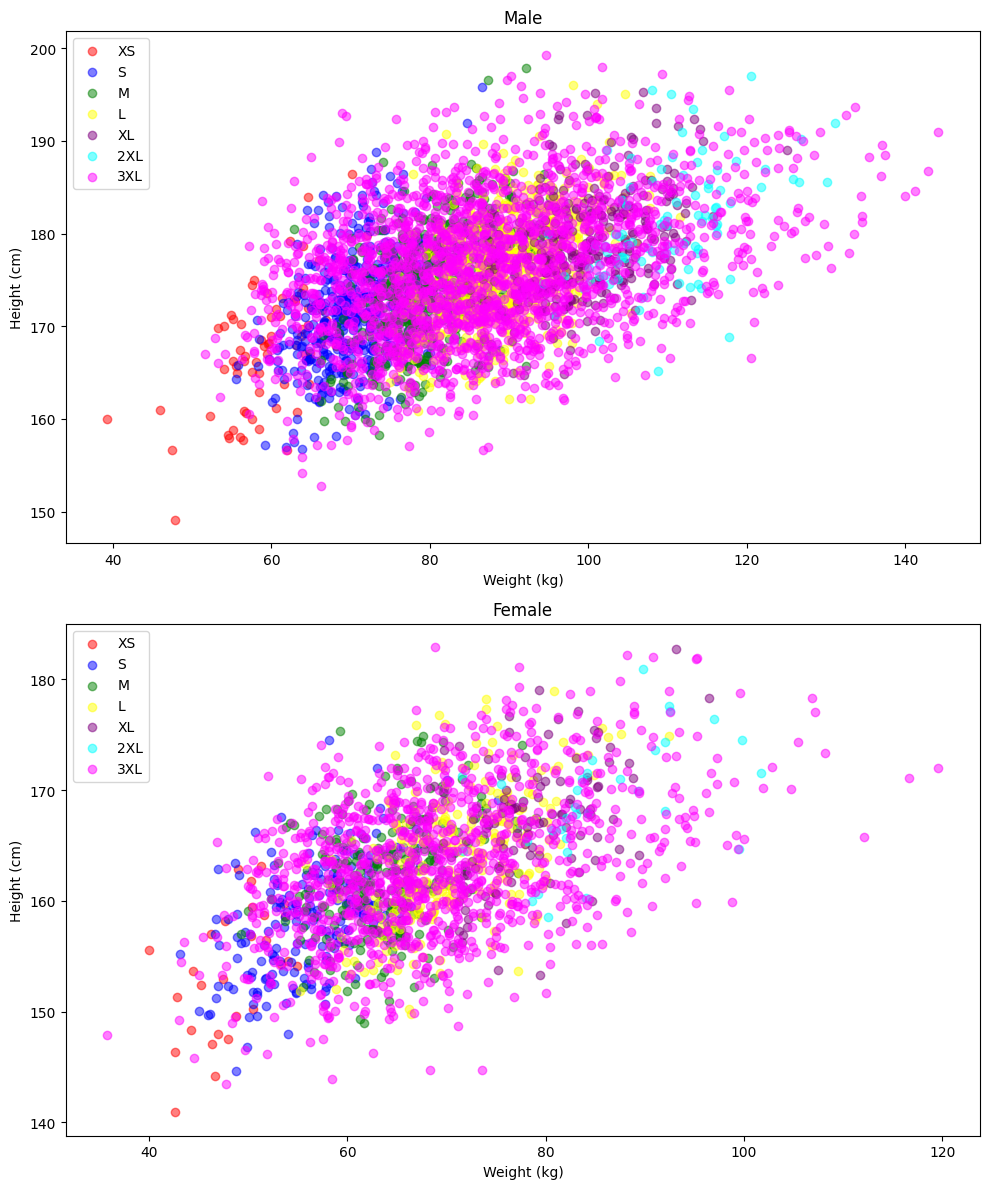

: 

In [ ]:
import matplotlib.pyplot as plt
colors = {
    'XS': 'red',
    'S': 'blue',
    'M': 'green',
    'L': 'yellow',
    'XL': 'purple',
    '2XL': 'cyan',
    '3XL': 'magenta'
}
male_dataset = pd.read_csv('./data/male_with_declaredsize1.csv')
female_dataset = pd.read_csv('./data/female_with_declaredsize1.csv')
# For male_dataset
male_dataset.loc[:, 'stature'] = male_dataset['stature'] / 10
male_dataset.loc[:, 'weightkg'] = male_dataset['weightkg'] / 10

# For female_dataset
female_dataset.loc[:, 'stature'] = female_dataset['stature'] / 10
female_dataset.loc[:, 'weightkg'] = female_dataset['weightkg'] / 10

# Create plots for each gender
fig, axes = plt.subplots(nrows=2, figsize=(10, 12))

for ax, gender_data, gender in zip(axes, [male_dataset, female_dataset], ["Male", "Female"]):
    for size, color in colors.items():
        # Filter data by size
        size_data = gender_data[gender_data["t-shirt size"] == size]

        # Plot data
        ax.scatter(size_data["weightkg"], size_data["stature"], c=color, label=size, alpha=0.5)

    ax.set_title(gender)
    ax.set_xlabel("Weight (kg)")
    ax.set_ylabel("Height (cm)")
    ax.legend()

plt.tight_layout()
plt.show()
